In [1]:
# Import Python Mobules
import os, json, time, argparse
import numpy as np
from sys import argv
import tensorflow as tf
import tensorflow.keras as keras

# Reduce warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Basic information
print("Modules: Imported")

Modules: Imported


In [2]:
# Command line arguments

buildEnv = False

parser = argparse.ArgumentParser()
parser.add_argument( '-runName', )
parser.add_argument( '-modelLoc', )
parser.add_argument( "-tid", default = '587722984435351614',  type=str )
parser.add_argument( "-start",   default = 0,    type=int, )
parser.add_argument( "-stop",    default = 3,  type=int, )
parser.add_argument( "-verbose", default = 0,    type=int, )
parser.add_argument( "-num_epochs",    default=2,   type=int )
parser.add_argument( "-learning_rate", default=0.01, type=float )
parser.add_argument( "-batch_size",    default=16,  type=int )
parser.add_argument( "-save_model",    default=True,  type=bool )

# Core Model types
parser.add_argument( "-model", default = 'efficientNetB1', )
parser.add_argument( "-pool",   default = None )
parser.add_argument( "-weights", default = 'imagenet',  type=str )

# Final layers
parser.add_argument( "-f_depth", default = 3,  type=int )
parser.add_argument( "-f_width", default = 32, type=int )
parser.add_argument( "-f_activation", default = 'tanh', type=str )
parser.add_argument( "-output_activation", default = None )

print("Args: Initialized")

Args: Initialized


In [16]:

# Am I in a jupyter notebook?
try:
    get_ipython().__class__.__name__
    buildEnv = True
    print("In Notebook")
    
    cmdStr = ''
    cmdStr += ' -runName test-efficient'
    cmdStr += ' -start 1'
    cmdStr += ' -stop 20'
    cmdStr += ' -num_epochs 20'
    cmdStr += ' -learning_rate 0.00001'
    cmdStr += ' -pool None'
    cmdStr += ' -verbose 1'
    cmdStr += ' -save_model False'
    cmdStr += ' -f_depth 3'
    cmdStr += ' -f_width 32'
    cmdStr += ' -f_activation tanh'
    # cmdStr += ' -output_activation softmax'
    
    # Read string as if command line
    args = parser.parse_args(cmdStr.split())


# Or am I in a python script?
except:
    args = parser.parse_args()
    
    # Check for valid runName
    print( 'runName: ', args.runName )
    if args.runName == None:
        print("WARNING:  runName required")
        exit()
    
    runName = args.runName

if buildEnv: 
    import matplotlib.pyplot as plt

print("Args: Read")

In Notebook
Args: Read


In [4]:

# Read current devices
devices = tf.config.get_visible_devices()

# If no GPU found, use CPU
if len(devices) == 1:
    strategy = tf.distribute.OneDeviceStrategy('CPU') # Use local GPU

# if buildEnv, probably on hamilton. Use GPU 2
elif buildEnv:
    tf.config.set_visible_devices(devices[0:1]+devices[2:3])
    tf.config.experimental.set_memory_growth(devices[1],True)
    strategy = tf.distribute.OneDeviceStrategy('GPU:1') # Use local GPU

# Standard single GPU on backus
else:
    tf.config.experimental.set_memory_growth(devices[1],True)
    strategy = tf.distribute.OneDeviceStrategy('GPU:1') # Use local GPU
if buildEnv:    print( 'Devices:', devices )


Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [5]:
def sliceKey( dictIn ):
    dictOut =  dictIn
    for k in dictOut:
        if type( dictOut[k] ) == type( 'string' ):
            if 'slice' in dictOut[k]:
                #print( k, dictOut[k] )
                tmp = dictOut[k].split('(')[1].split(')')[0].split(',')
                s = int( tmp[0] )
                e = int( tmp[1] )
                dictOut[k] = slice( s, e )
                #print( dictOut[k] )
    
    return dictOut 


with strategy.scope():
    
    # Prepare data
    with open( 'data/data-key.json' ) as keyFile:
        key = json.load( keyFile )
    
    key = sliceKey( key )
    
    print( key.keys() )

dict_keys(['score', 'model', 'min', 'rid', 'tid', 'targets', 'images'])


In [20]:

def loadData( args ):
    
    # Prepare data
    with open( 'data/data-key.json' ) as keyFile:
        key = json.load( keyFile )
    
    print("Reading Data for: %s" % args.tid )
        
    data = np.load('data/norm-targets/data-%s.npy' % args.tid)
    img = np.load( 'data/raw/img-%s.npy' % args.tid )
    
    # Rescale image values based on core model being used.
    if 'efficientNet' in args.model :
        img *= 255

    if buildEnv:
        print( 'data: ', data.shape )
        print( 'img:  ', img.shape, np.amin(img), np.amax(img) )
        
        
    
    # Reserve every 5th for training
    n = data.shape[0]
    m = np.full( n, False )
    m[::5] = True
    
    # Seperate training from testing
    testData = data[m] 
    testImg  = img[m]
    
    trainData = data[~m]
    trainImg = img[~m]
    
    # Shuffle training data
    
    p = np.random.permutation( trainData.shape[0] )
    trainData = trainData[p]
    trainImg = trainImg[p]
    
    if buildEnv:
        print( "test:  ", testData.shape )
        print( "train: ", trainData.shape )
    
    # Only grab scores for prediction    
    trainScore = trainData[:,key['score']]
    testScore  =  testData[:,key['score']]
    
    # Reshape scores
    testScore  = np.reshape( testScore,  (  testScore.shape[0], 1 ) )
    trainScore = np.reshape( trainScore, ( trainScore.shape[0], 1 ) )
    
    # print scores shape
    
    if buildEnv:
        print('testScore:', testScore.shape, np.amin( testScore ), np.amax(testScore) )
        print("trainScore:", trainScore.shape )
    
    # Set standardized name
    
    return trainImg, trainScore, testImg, testScore
    
with strategy.scope():
    X, Y, testImg, testScore = loadData( args )

Reading Data for: 587722984435351614
data:  (315, 25)
img:   (315, 128, 128, 3) 0.0 255.0
test:   (63, 25)
train:  (252, 25)
testScore: (63, 1) 0.02857142857142857 0.9459459459459459
trainScore: (252, 1)


In [7]:
def correlation(y_true, y_pred):
    y = y_pred.numpy()
    corr = np.corrcoef( y_true[:,0], y[:,0] )[0,1]
    return corr


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 4, 4, 1280)       6575239   
                                                                 
 flatten_2 (Flatten)         (None, 20480)             0         
                                                                 
 act_tanh_0 (Dense)          (None, 32)                655392    
                                                                 
 act_tanh_1 (Dense)          (None, 32)                1056      
                                                                 
 act_tanh_2 (Dense)          (None, 32)                1056      
                                                                 
 output_linear (Dense)       (None, 1)                 33  

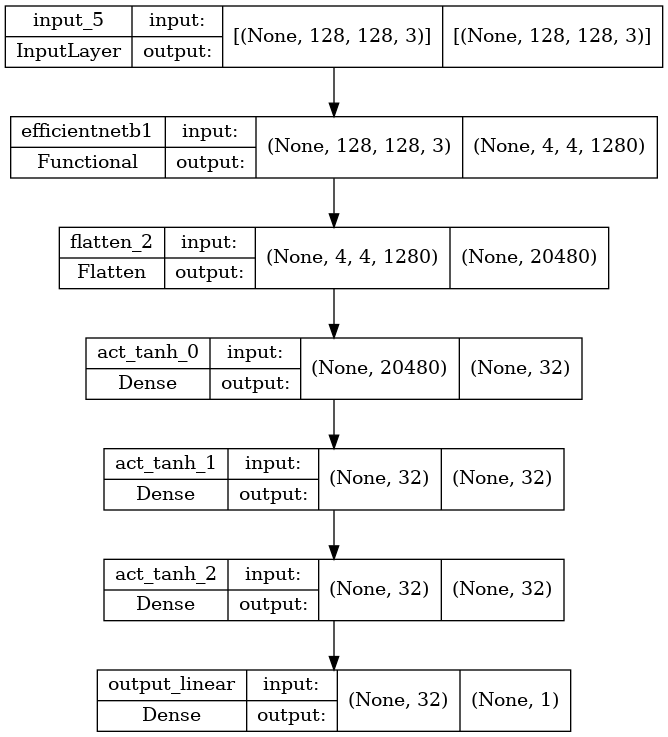

In [22]:
   

def buildModel( args, X, Y ):
    
    # Build input layer
    x = keras.layers.Input(shape=X.shape[1:])
    y = x    
    
    # What type of model
    
    if 'efficientNet' in args.model:
    
        if   args.model == 'efficientNetB0':  core_model = tf.keras.applications.EfficientNetB0
        elif args.model == 'efficientNetB1':  core_model = tf.keras.applications.EfficientNetB1
        elif args.model == 'efficientNetB2':  core_model = tf.keras.applications.EfficientNetB2
        elif args.model == 'efficientNetB3':  core_model = tf.keras.applications.EfficientNetB3
        elif args.model == 'efficientNetB4':  core_model = tf.keras.applications.EfficientNetB4
        elif args.model == 'efficientNetB5':  core_model = tf.keras.applications.EfficientNetB5
        elif args.model == 'efficientNetB6':  core_model = tf.keras.applications.EfficientNetB6
        elif args.model == 'efficientNetB7':  core_model = tf.keras.applications.EfficientNetB7
            
        core_model =  core_model(
                include_top=False,
                weights=args.weights,
                input_shape=y.shape[1:],
                pooling=args.pool,
            )
    
    elif args.model == 'resnet':
        # Build resnet layer without top layer
        core_model = keras.applications.ResNet50V2(
            include_top = False,
            weights = args.weights,
            input_shape = y.shape[1:], 
        )
    else:
        print("NO MODEL TYPE SELECTED")
        return None
    
    # Add core model
    y = core_model(y)
    
    # Flatten for final layers
    y = keras.layers.Flatten()(y)
    
    for i in range( args.f_depth ):
        
        if args.f_activation == None:
            y = keras.layers.Dense( args.f_width, activation= keras.activations.relu, name='act_relu_%d'%i )(y)
            
        if args.f_activation == 'relu':
            y = keras.layers.Dense( args.f_width, activation= keras.activations.relu, name='act_relu_%d'%i )(y)
            
        if args.f_activation == 'tanh':
            y = keras.layers.Dense( args.f_width, activation= keras.activations.tanh, name='act_tanh_%d'%i )(y)
    
    # Final layer.
    if args.output_activation == None:
        y = keras.layers.Dense( Y.shape[1], name='output_linear' )(y)
        
    elif args.output_activation == 'softmax':
        y = keras.layers.Dense( Y.shape[1] , activation='softmax', name='output_softmax' )(y)
        
    elif args.output_activation == 'sigmoid':
        y = keras.layers.Dense( Y.shape[1] , activation='sigmoid', name='output_sigmoid' )(y)


    # Compile
    model = keras.Model( x, y )
    model.compile( 
        optimizer=keras.optimizers.Adam(learning_rate= args.learning_rate ),
        loss=keras.losses.mean_squared_error,
        )
    
    return model
# end building model
    
with strategy.scope(): 

    # If not reading previous model, make fresh model
    if args.modelLoc == None:
        model = buildModel( args, trainImg, trainScore )
    
    model.summary(expand_nested=False)
    
keras.utils.plot_model(model,show_shapes=True,expand_nested=False)

    

In [9]:
with strategy.scope(): 
        
    # Quick prediction to test functionality
    if buildEnv: 
        print("Prediction 2: ", model.predict( testImg[:10] ))

Prediction 2:  [[-1.26791   ]
 [-1.0475323 ]
 [-0.9360438 ]
 [-0.83525324]
 [-0.85395545]
 [-1.1047075 ]
 [-1.1485577 ]
 [-0.92465925]
 [-1.0555538 ]
 [-0.7239177 ]]


In [10]:
with strategy.scope():
        
    data_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=180,
        zoom_range=0.1,
        horizontal_flip=True,
    )

    dg_trainer = data_generator.flow( 
        X, Y, 
        batch_size = args.batch_size
    )
    
    print( 'Ready to Train:' )
    print( 'runName: %s' % args.runName )
    print( 'start: %d' % args.start )
    print( 'goal: %d' % args.stop )
    
    with open( 'results/%s.txt' % args.runName, 'a' ) as f: 
        
        print( 'runName: %s' % args.runName, file=f )
        print( 'start: %d' % args.start, file=f )
        print( 'goal: %d' % args.stop, file=f )
    
    # Initialize iter
    i = args.start   
    
    while i < args.stop:

        history = model.fit(
           dg_trainer,
#             X, Y,
            validation_data = ( Xval, Yval ),
            epochs     = args.num_epochs,
            verbose    = args.verbose,
        )

        i += args.num_epochs
        timeid = int( time.time() )
        
        print( 'Progress: %d - %d' % ( i, args.stop ) )
        
        if args.save_model: 
            model.save( 'models/%s-%s-%s.h5' % (args.runName, str(timeid), str(i)), save_format='h5' )

        with open( 'results/%s.txt' % args.runName, 'a' ) as f: 

            print( 'Progress: %d - %d' % ( i, timeid ), file=f )
            print( "Validation accuracy:",*["%.8f"%(x) for x in history.history['loss']], file=f)    
            print( "Test accuracy:",*["%.8f"%(x) for x in history.history['val_loss']],file=f)


Ready to Train:
runName: test-efficient
start: 1
goal: 20
Epoch 1/20
16/16 [==============================] - 13s 346ms/step - loss: 0.2502 - val_loss: 0.8934
Epoch 2/20
16/16 [==============================] - 1s 69ms/step - loss: 0.1471 - val_loss: 0.3190
Epoch 3/20
16/16 [==============================] - 1s 70ms/step - loss: 0.1069 - val_loss: 0.0845
Epoch 4/20
16/16 [==============================] - 1s 67ms/step - loss: 0.0818 - val_loss: 0.0964
Epoch 5/20
16/16 [==============================] - 1s 64ms/step - loss: 0.0660 - val_loss: 0.1235
Epoch 6/20
16/16 [==============================] - 1s 66ms/step - loss: 0.0498 - val_loss: 0.1209
Epoch 7/20
16/16 [==============================] - 1s 68ms/step - loss: 0.0519 - val_loss: 0.1094
Epoch 8/20
16/16 [==============================] - 1s 67ms/step - loss: 0.0416 - val_loss: 0.0972
Epoch 9/20
16/16 [==============================] - 1s 64ms/step - loss: 0.0446 - val_loss: 0.1220
Epoch 10/20
16/16 [==============================

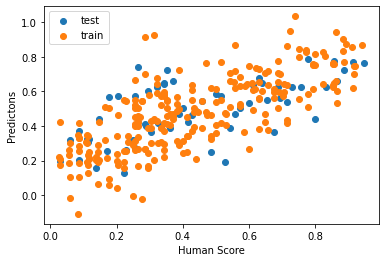

In [19]:
pTestScores = model.predict( testImg )
pTrainScores = model.predict( trainImg )


if buildEnv: 
    plt.scatter( testScore, pTestScores, label='test' )
    plt.scatter( trainScore, pTrainScores, label='train' ) 
    
    plt.xlabel('Human Score')
    plt.ylabel('Predictons')
    plt.legend()



dict_keys(['loss', 'val_loss'])


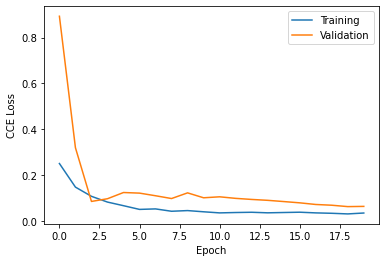

In [17]:
if buildEnv: 
    print( history.history.keys() )
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['Training','Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('CCE Loss')
    #plt.ylim([0,1])
    plt.show()


In [18]:
with strategy.scope():     
    
    print("Changing Learning Rate: ", args.learning_rate )
    keras.backend.set_value( 
        model.optimizer.learning_rate, 
        float( args.learning_rate ) 
    )
    
    history = model.fit(
       dg_trainer,
#             X, Y,
        validation_data = ( Xval, Yval ),
        epochs     = args.num_epochs,
        verbose    = args.verbose,
    )

Changing Learning Rate:  1e-05
Epoch 1/20
16/16 [==============================] - 1s 66ms/step - loss: 0.0306 - val_loss: 0.0631
Epoch 2/20
16/16 [==============================] - 1s 70ms/step - loss: 0.0309 - val_loss: 0.0646
Epoch 3/20
16/16 [==============================] - 1s 65ms/step - loss: 0.0313 - val_loss: 0.0675
Epoch 4/20
16/16 [==============================] - 1s 67ms/step - loss: 0.0329 - val_loss: 0.0678
Epoch 5/20
16/16 [==============================] - 1s 68ms/step - loss: 0.0314 - val_loss: 0.0683
Epoch 6/20
16/16 [==============================] - 1s 65ms/step - loss: 0.0330 - val_loss: 0.0658
Epoch 7/20
16/16 [==============================] - 1s 68ms/step - loss: 0.0300 - val_loss: 0.0589
Epoch 8/20
16/16 [==============================] - 1s 68ms/step - loss: 0.0320 - val_loss: 0.0522
Epoch 9/20
16/16 [==============================] - 1s 70ms/step - loss: 0.0287 - val_loss: 0.0488
Epoch 10/20
16/16 [==============================] - 1s 67ms/step - loss: 0.03